100%|██████████| 26421880/26421880 [00:05<00:00, 4903571.48it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207854.61it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3716086.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7236017.76it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Starting Training Loop...
Epoch [1/25] Batch [0/469] Loss D: 1.3148, Loss G: 2.3905, D(x): 0.5451, D(G(z)): 0.4954 / 0.0960
Epoch [1/25] Batch [100/469] Loss D: 0.0053, Loss G: 8.0353, D(x): 0.9968, D(G(z)): 0.0021 / 0.0004
Epoch [1/25] Batch [200/469] Loss D: 0.6664, Loss G: 1.6517, D(x): 0.6729, D(G(z)): 0.1988 / 0.2034
Epoch [1/25] Batch [300/469] Loss D: 0.4955, Loss G: 1.9719, D(x): 0.7854, D(G(z)): 0.2089 / 0.1570
Epoch [1/25] Batch [400/469] Loss D: 0.5227, Loss G: 1.8394, D(x): 0.7168, D(G(z)): 0.1314 / 0.1808
Epoch [2/25] Batch [0/469] Loss D: 1.1582, Loss G: 2.5391, D(x): 0.8582, D(G(z)): 0.5931 / 0.0916
Epoch [2/25] Batch [100/469] Loss D: 0.2737, Loss G: 3.3432, D(x): 0.9145, D(G(z)): 0.1586 / 0.0442
Epoch [2/25] Batch [200/469] Loss D: 0.7081, Loss G: 2.5471, D(x): 0.7949, D(G(z)): 0.3433 / 0.0992
Epoch [2/25] Batch [300/469] Loss D: 0.4512, Loss G: 2.4989, D(x): 0.8975, D(G(z)): 0.260

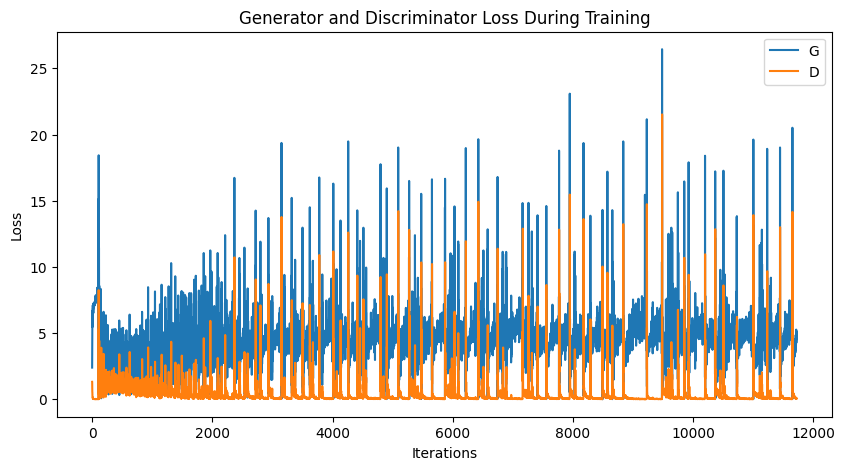

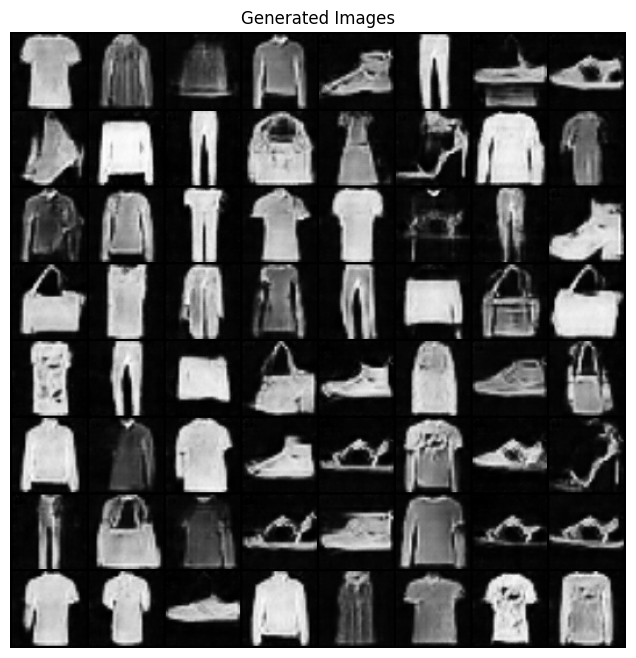

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
image_size = 64
batch_size = 128
nz = 100  # Size of latent vector (input to generator)
ngf = 64  # Feature map size for generator
ndf = 64  # Feature map size for discriminator
num_epochs = 25
lr = 0.0002
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformation and loading
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize the models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                  f'Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}, '
                  f'D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save images generated by the generator
        if (epoch == num_epochs - 1) and (i % 100 == 0):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualize generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()


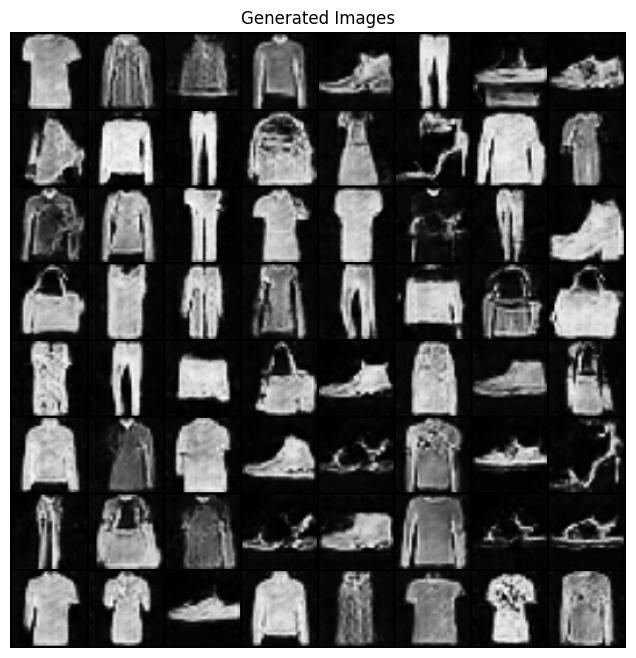

In [2]:
# Visualize generated images after training
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()


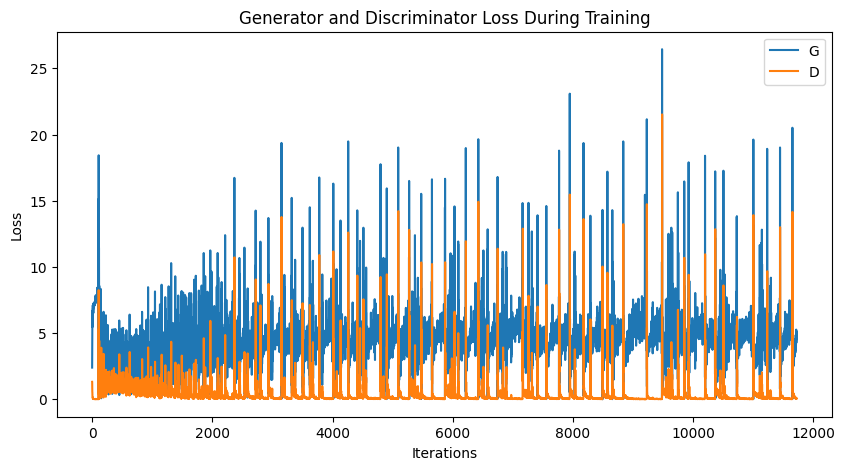

In [3]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


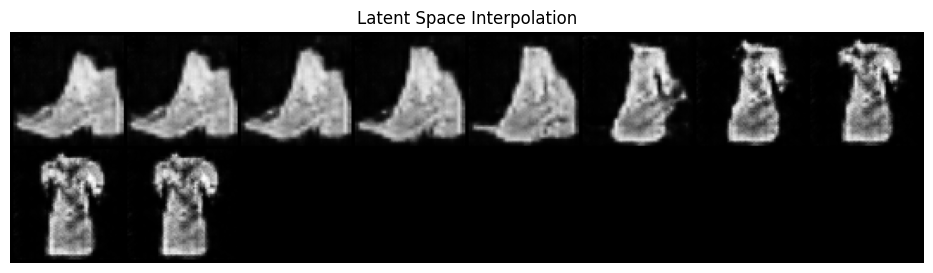

In [4]:
# Interpolate between two random points in the latent space
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
alpha_values = np.linspace(0, 1, 10)
interpolations = []
for alpha in alpha_values:
    z_interp = (1 - alpha) * z1 + alpha * z2
    with torch.no_grad():
        img_interp = netG(z_interp).detach().cpu()
    interpolations.append(img_interp)

# Plot the interpolations
interpolations = torch.cat(interpolations)
plt.figure(figsize=(15, 3))
plt.axis("off")
plt.title("Latent Space Interpolation")
plt.imshow(np.transpose(vutils.make_grid(interpolations, padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [5]:
import torch

# Save the Generator model after training
torch.save(netG.state_dict(), 'model.pkl')


In [6]:
import torch

# Initialize the Generator model
netG = Generator().to(device)

# Load the trained parameters into the Generator
netG.load_state_dict(torch.load('model.pkl'))

# Ensure the model is in evaluation mode
netG.eval()

# Now you can use the model to generate images as before


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [9]:
# After training, save the generator model
torch.save(netG.state_dict(), 'model.pkl')
print("Generator model saved to model.pkl")


Generator model saved to model.pkl
